original https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification/notebook thanks to phoenigs

# Import

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [1]:
import numpy as np
import pandas as pd

from random import randint,choice

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from skimage import filters

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

Using TensorFlow backend.


# Params and helpers

In [3]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

# Loading of training/testing ids and depths
Reading the training data, store it in a DataFrame.

In [3]:
train_df = pd.read_csv("./input/train.csv", index_col="id", usecols=[0])

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [6]:
train_df["images"] = [np.array(load_img("./input/train/images/{}.png".format(idx),color_mode = 'grayscale')) / 255 for idx in tqdm_notebook(train_df.index)]

In [7]:
train_df["masks"] = [np.array(load_img("./input/train/masks/{}.png".format(idx),color_mode = 'grayscale')) / 255 for idx in tqdm_notebook(train_df.index)]

# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [8]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [9]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5, 0, 'Coverage class')

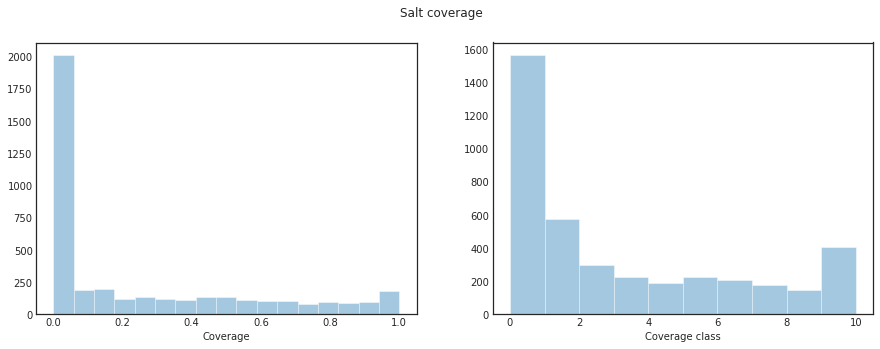

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

# Show some example images

Text(0.5, 0.98, 'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

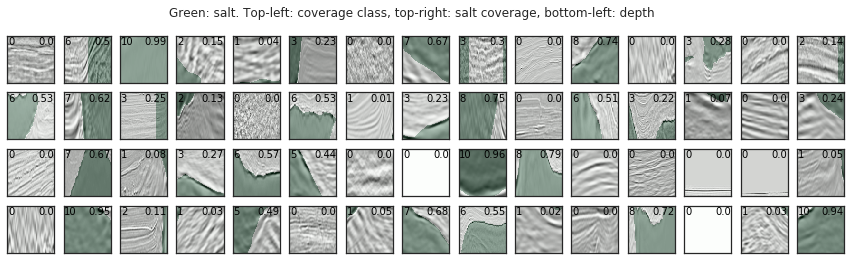

In [11]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

## Bigger images

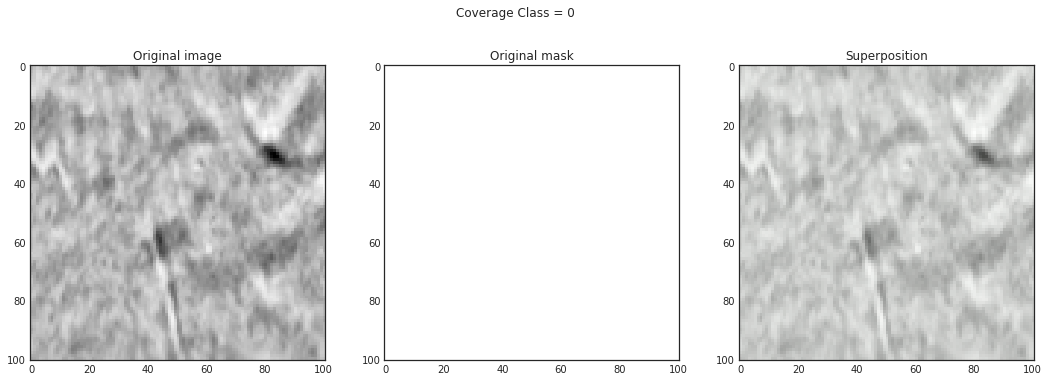

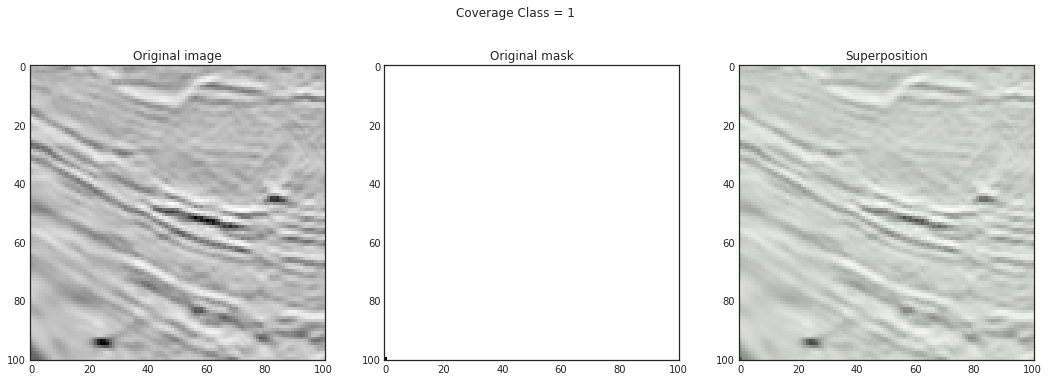

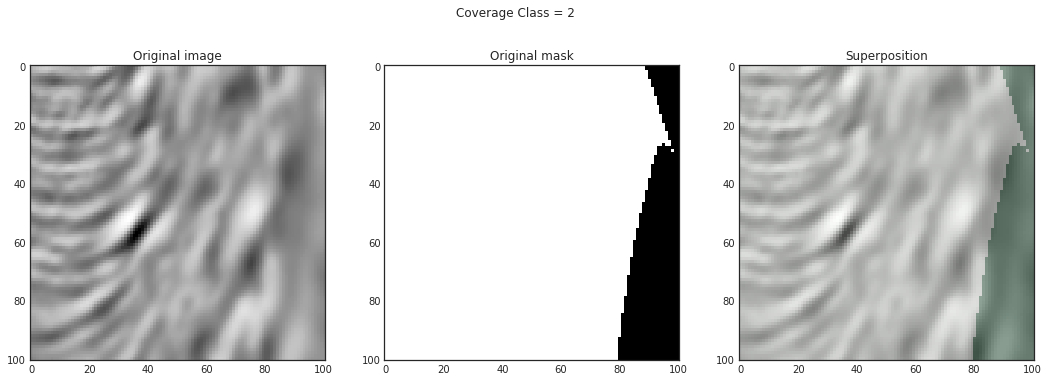

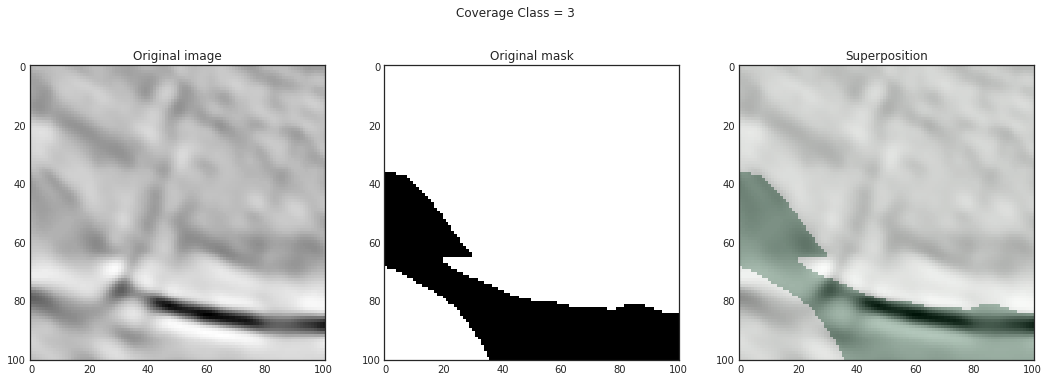

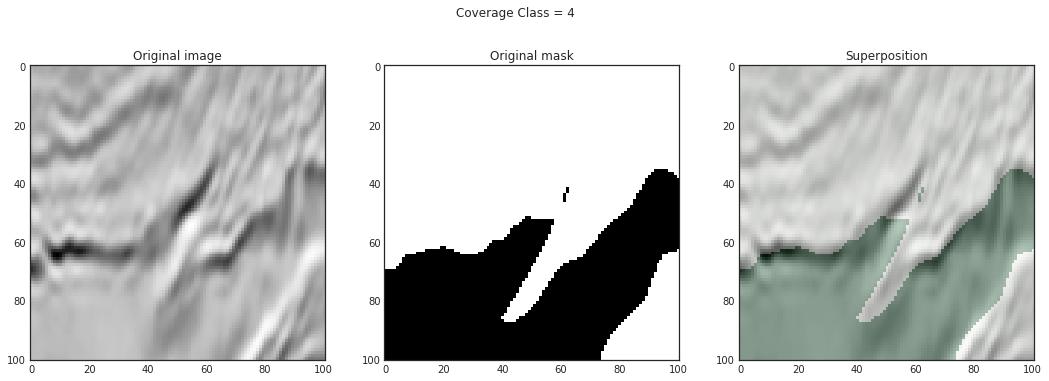

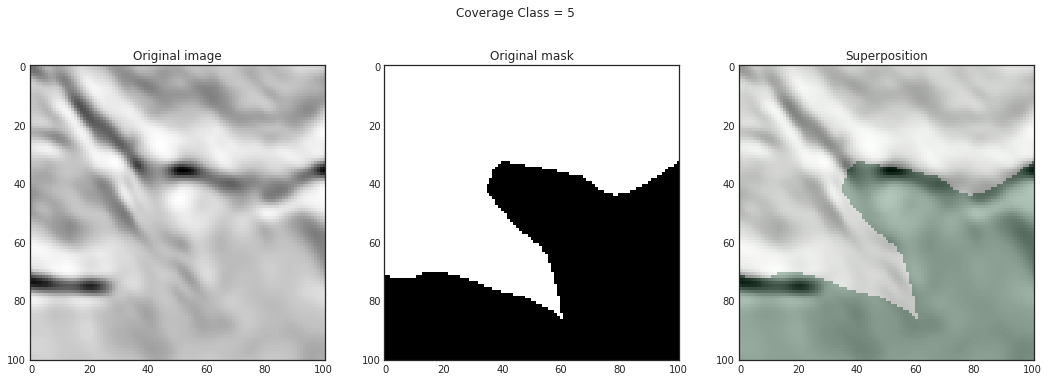

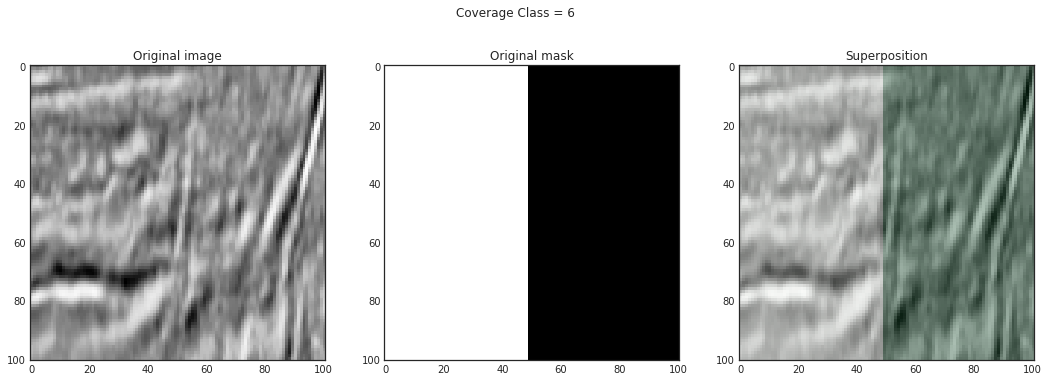

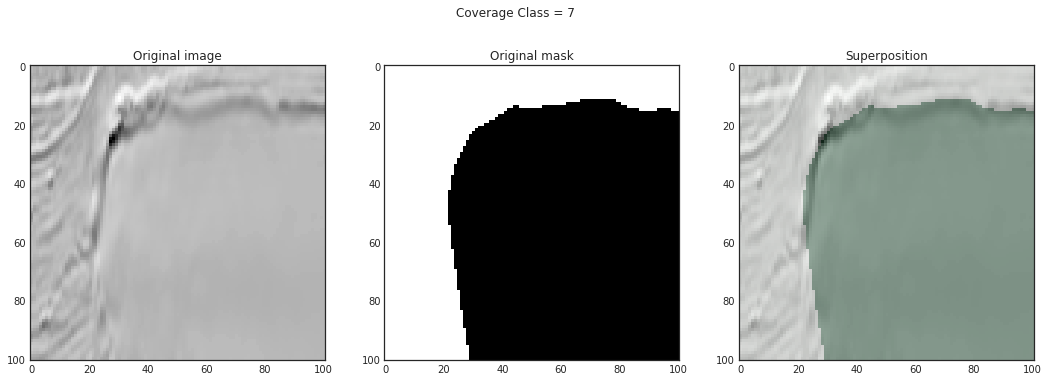

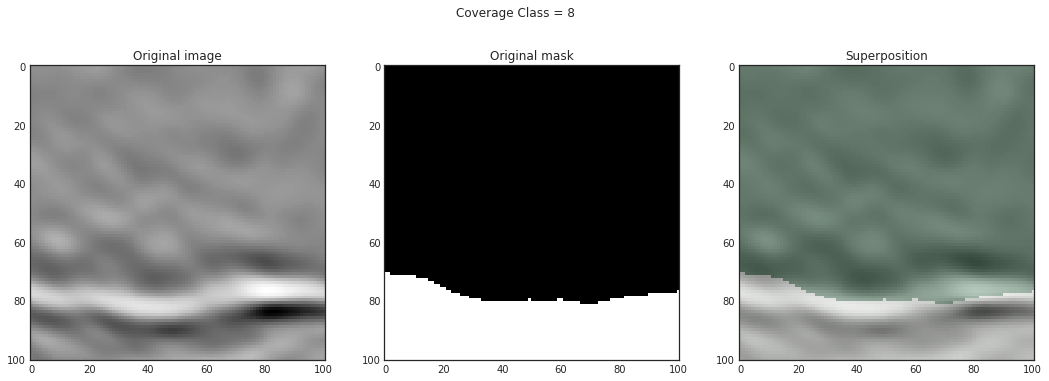

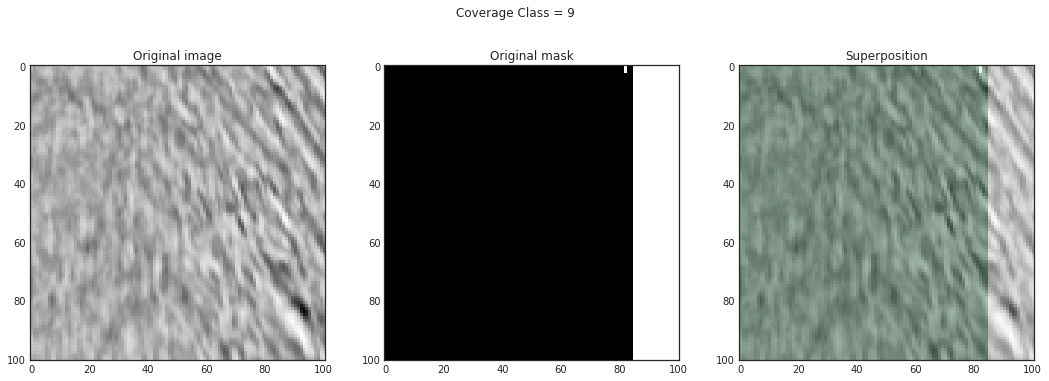

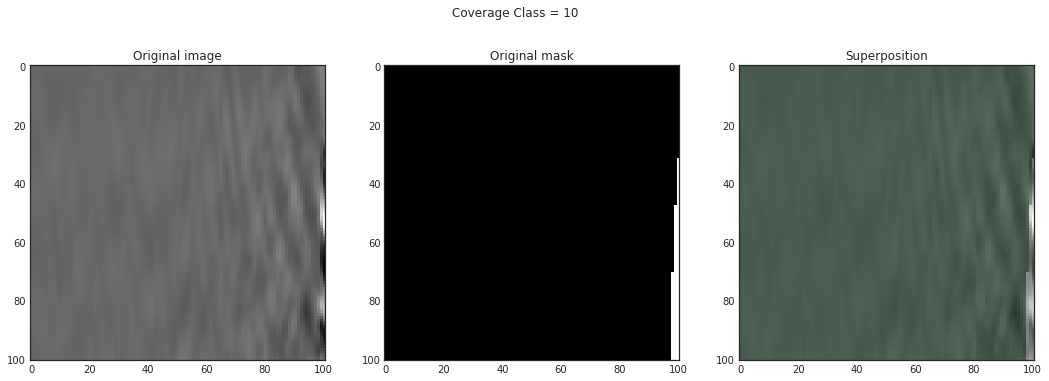

In [12]:
for i in range(11):
    indx = choice(train_df[train_df.coverage_class==i].index)
    img = train_df.loc[indx].images
    mask = train_df.loc[indx].masks
    _, ax = plt.subplots(nrows=1, 
                         ncols=3, 
                         figsize=(18, 6))
    ax[0].imshow(img, cmap="Greys");
    ax[0].set_title('Original image')
    ax[1].imshow(mask, cmap="Greys");
    ax[1].set_title('Original mask')
    ax[2].imshow(img, cmap="Greys")
    ax[2].imshow(mask, alpha=0.3, cmap="Greens");
    ax[2].set_title('Superposition');
    plt.suptitle("Coverage Class = {}".format(i))
    plt.show()


# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [ ]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test = \
    train_test_split(
        train_df.index.values,
        np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
        np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
        train_df.coverage.values,
        test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

In [ ]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

In [ ]:
df_valid = train_df.loc[ids_valid]

# Build model

In [ ]:
def build_model(input_layer, start_neurons):
    kernel_size = (3, 3)
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, kernel_size, activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, kernel_size, activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, kernel_size, activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, kernel_size, activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, kernel_size, activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, kernel_size, activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, kernel_size, activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, kernel_size, activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, kernel_size, activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, kernel_size, activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, kernel_size, strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, kernel_size, activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, kernel_size, activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, kernel_size, strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, kernel_size, activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, kernel_size, activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, kernel_size, strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, kernel_size, activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, kernel_size, activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, kernel_size, strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, kernel_size, activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, kernel_size, activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [ ]:
model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

# Data augmentation

## Flip

In [ ]:
flip_x = [np.fliplr(x) for x in x_train]
flip_y = [np.fliplr(y) for y in y_train]

In [ ]:
for i in range(2):
    indx = randint(0,x_train.shape[0])
    _, ax = plt.subplots(nrows=1, 
                         ncols=2, 
                         figsize=(18, 8))
    img = x_train[indx].squeeze()
    mask = y_train[indx].squeeze()
    
    img_flip = flip_x[indx].squeeze()
    mask_flip = flip_y[indx].squeeze()
    
    ax[0].imshow(img, cmap="Greys")
    ax[0].imshow(mask, alpha=0.3, cmap="Greens");
    ax[0].set_title('Original image+mask');
    
    ax[1].imshow(img_flip, cmap="Greys")
    ax[1].imshow(mask_flip, alpha=0.3, cmap="Greens");
    ax[1].set_title('Flipped image+mask');    

## Crop

In [ ]:
crop_x = [x[x.shape[0] // 4: - x.shape[0] // 4, x.shape[1] // 4: - x.shape[1] // 4] for x in x_train]
crop_y = [y[y.shape[0] // 4: - y.shape[0] // 4, y.shape[1] // 4: - y.shape[1] // 4] for y in y_train]

crop_x = np.array(pd.Series(crop_x).map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
crop_y = np.array(pd.Series(crop_y).map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)

In [ ]:
for i in range(2):
    indx = randint(0,x_train.shape[0])
    _, ax = plt.subplots(nrows=1, 
                         ncols=2, 
                         figsize=(18, 8))
    img = x_train[indx].squeeze()
    mask = y_train[indx].squeeze()
    
    img_flip = crop_x[indx].squeeze()
    mask_flip = crop_y[indx].squeeze()
    
    ax[0].imshow(img, cmap="Greys")
    ax[0].imshow(mask, alpha=0.3, cmap="Greens");
    ax[0].set_title('Original image+mask');
    
    ax[1].imshow(img_flip, cmap="Greys")
    ax[1].imshow(mask_flip, alpha=0.3, cmap="Greens");
    ax[1].set_title('Cropped image+mask');    

## Shift Image

In [ ]:
def transform_image(X, shift=25):
    '''
    Return a shifted image with mirrored padding
    '''
    return np.concatenate([X, X[:, np.arange(X.shape[1]-2, 0, -1), :], X], axis=1)[:, shift:shift+X.shape[1], :]

In [ ]:
shift_x = [transform_image(x) for x in x_train]
shift_y = [transform_image(y) for y in y_train]

In [ ]:
for i in range(2):
    indx = randint(0,x_train.shape[0])
    _, ax = plt.subplots(nrows=1, 
                         ncols=2, 
                         figsize=(18, 8))
    img = x_train[indx].squeeze()
    mask = y_train[indx].squeeze()
    
    img_shift = shift_x[indx].squeeze()
    mask_shift = shift_y[indx].squeeze()
    
    ax[0].imshow(img, cmap="Greys")
    ax[0].imshow(mask, alpha=0.3, cmap="Greens");
    ax[0].set_title('Original image+mask');
    
    ax[1].imshow(img_shift, cmap="Greys")
    ax[1].imshow(mask_shift, alpha=0.3, cmap="Greens");
    ax[1].set_title('Shifted image+mask');    

## Concatenation

In [ ]:
#x_train = np.append(x_train, flip_x, axis=0)
#y_train = np.append(y_train, flip_y, axis=0)

#x_train = np.append(x_train, crop_x, axis=0)
#y_train = np.append(y_train, crop_y, axis=0)

x_train = np.append(x_train, shift_x, axis=0)
y_train = np.append(y_train, shift_y, axis=0)

# Training

In [151]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 100
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 12800 samples, validate on 800 samples
Epoch 1/100
12800/12800 [==============================] - 36s 3ms/step - loss: 0.1359 - acc: 0.9385 - val_loss: 0.1838 - val_acc: 0.9198

Epoch 00001: val_loss improved from inf to 0.18379, saving model to ./keras.model
Epoch 2/100
12800/12800 [==============================] - 36s 3ms/step - loss: 0.1359 - acc: 0.9383 - val_loss: 0.1836 - val_acc: 0.9198

Epoch 00002: val_loss improved from 0.18379 to 0.18359, saving model to ./keras.model
Epoch 3/100
12800/12800 [==============================] - 37s 3ms/step - loss: 0.1348 - acc: 0.9389 - val_loss: 0.1835 - val_acc: 0.9196

Epoch 00003: val_loss improved from 0.18359 to 0.18345, saving model to ./keras.model
Epoch 4/100
12800/12800 [==============================] - 37s 3ms/step - loss: 0.1344 - acc: 0.9388 - val_loss: 0.1835 - val_acc: 0.9195

Epoch 00004: val_loss did not improve from 0.18345
Epoch 5/100
12800/12800 [==============================] - 37s 3ms/step - loss: 0.1349 - ac

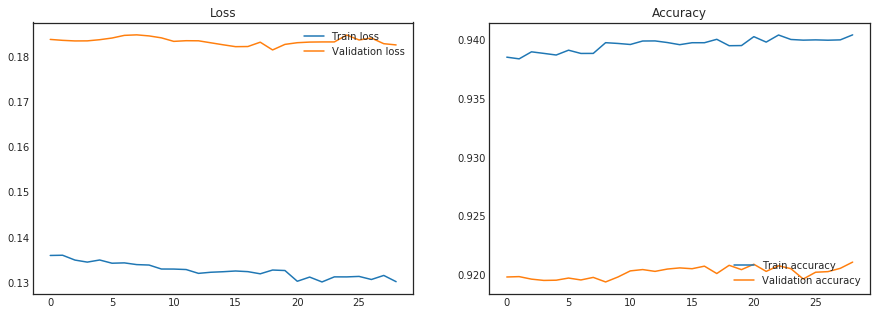

In [152]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.set_title("Loss")
ax_loss.legend(loc='upper right')

ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.set_title("Accuracy")
ax_acc.legend(loc='lower right')

In [98]:
model = load_model("./keras.model")

# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [153]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

In [156]:
threshold = 0.7
df_valid['pred'] = preds_valid.tolist()
pred_mask = np.int8(preds_valid > threshold)
df_valid['pred_mask'] = pred_mask.tolist()

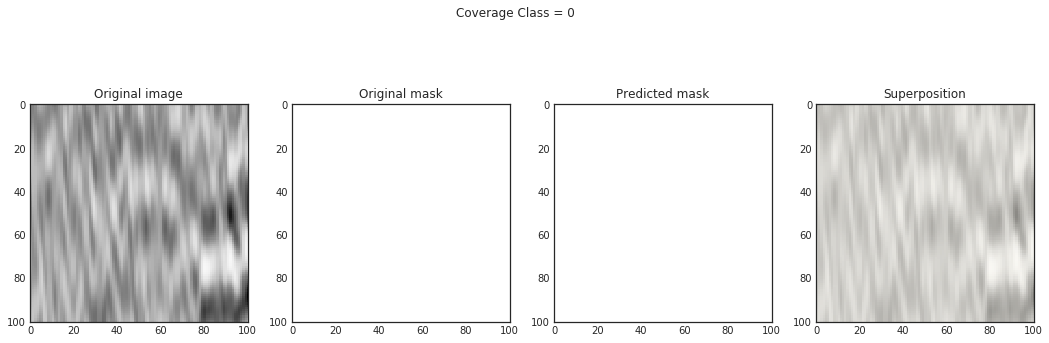

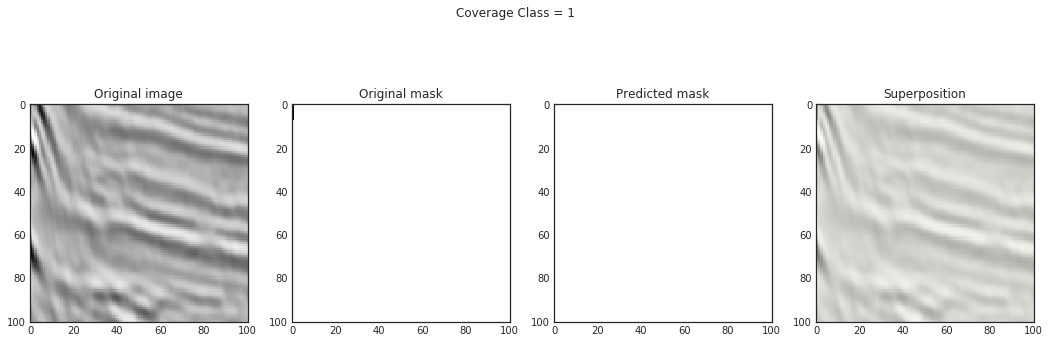

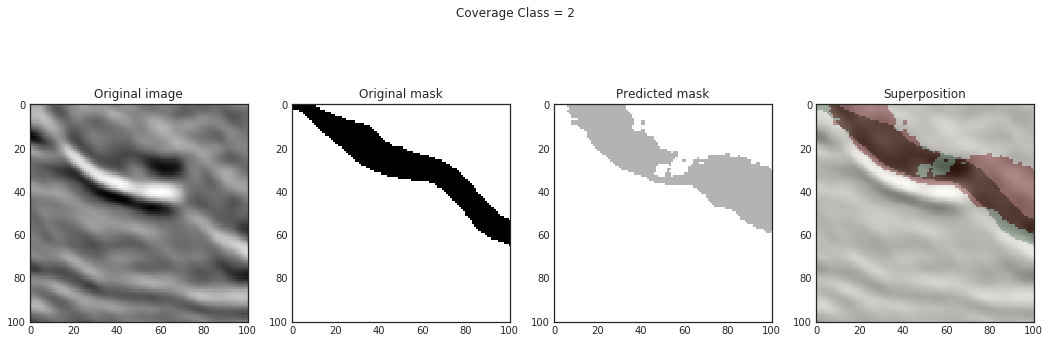

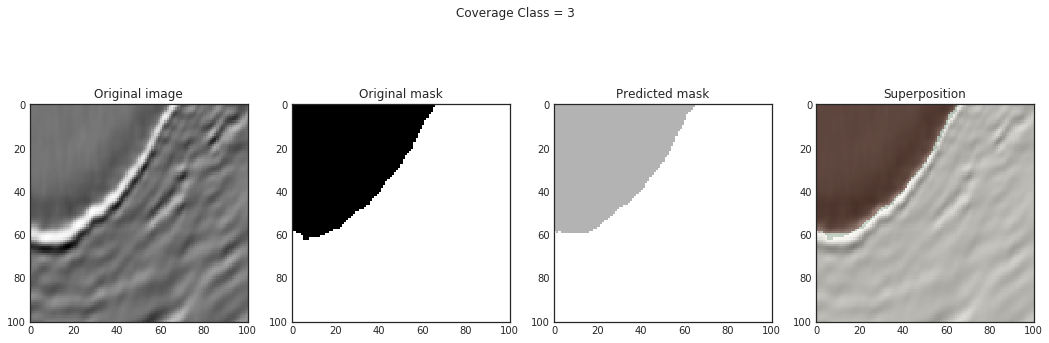

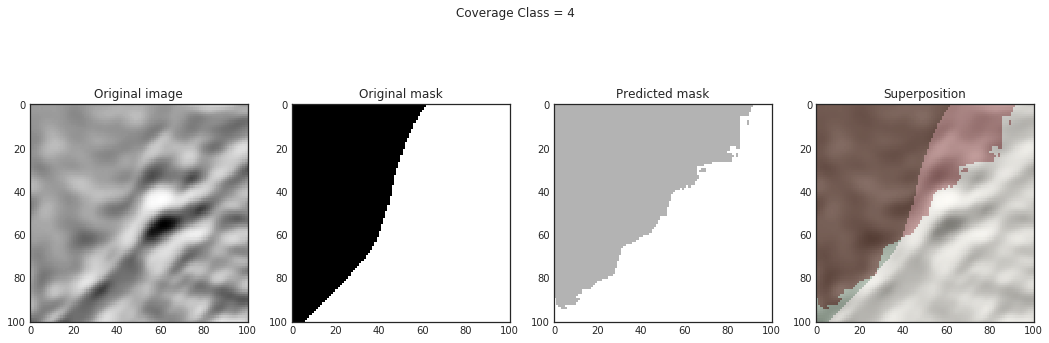

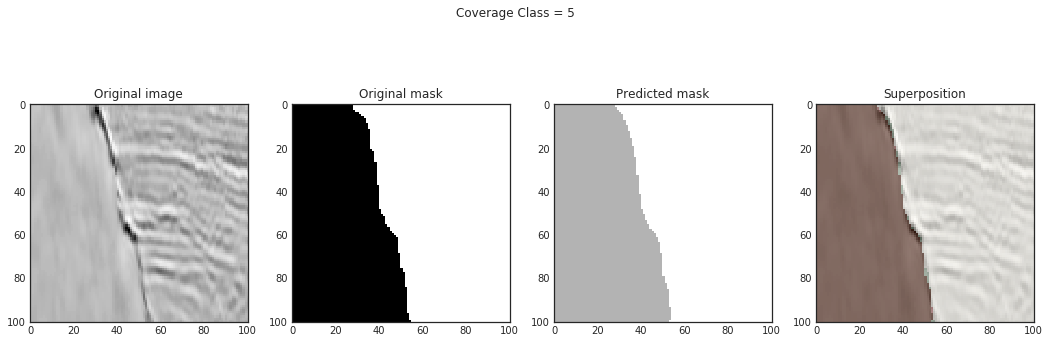

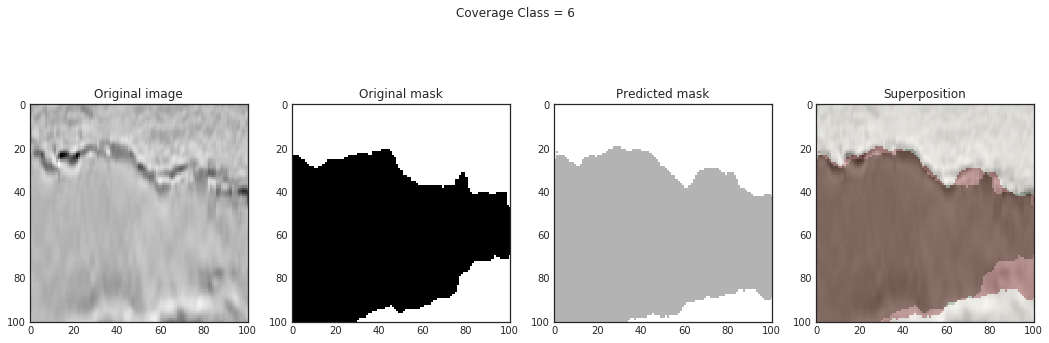

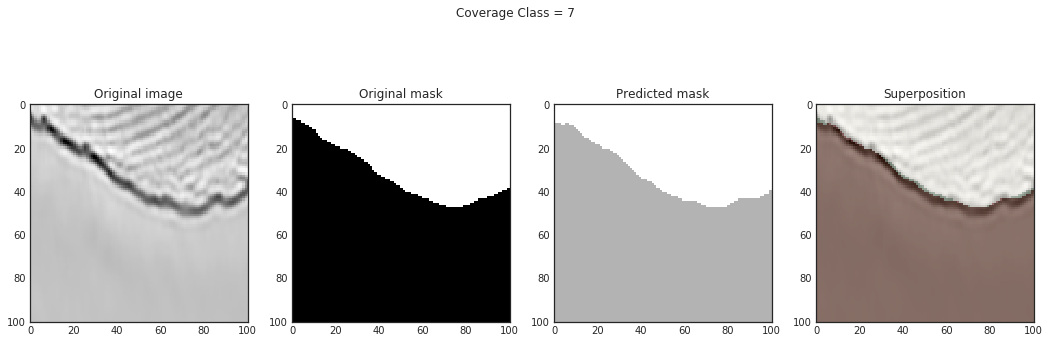

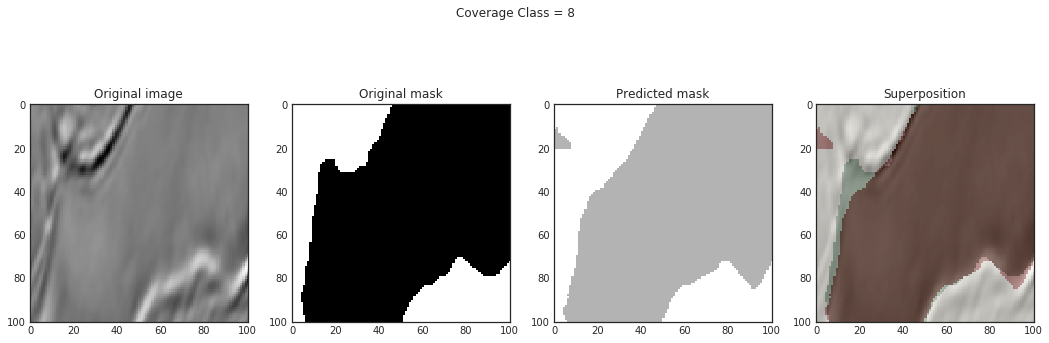

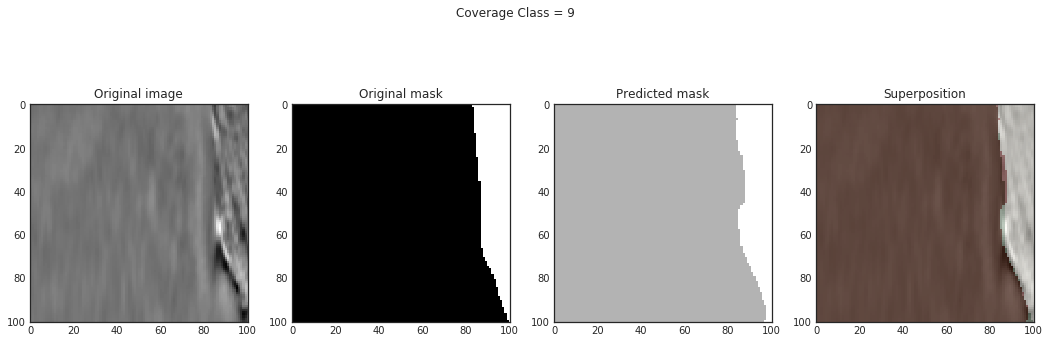

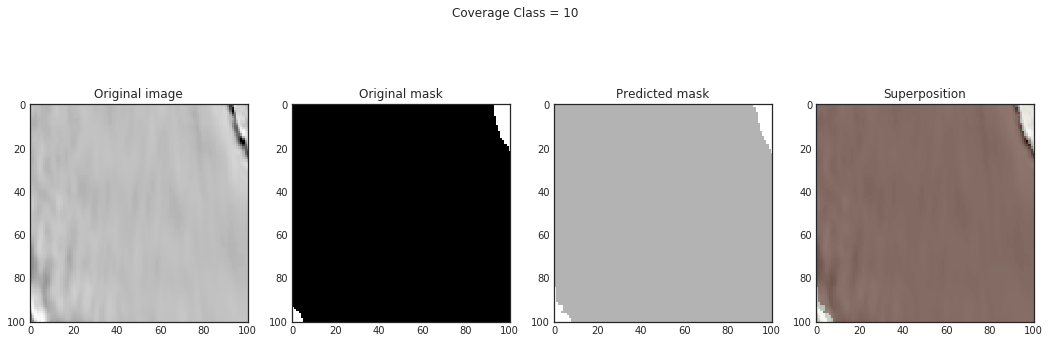

In [157]:
for i in range(11):
    indx = choice(df_valid[df_valid.coverage_class==i].index)
    img = df_valid.loc[indx].images
    mask = df_valid.loc[indx].masks
    pred_mask = df_valid.loc[indx].pred_mask
    _, ax = plt.subplots(nrows=1, 
                         ncols=4, 
                         figsize=(18, 6))
    ax[0].imshow(img, cmap="Greys");
    ax[0].set_title('Original image')
    ax[1].imshow(mask, cmap="Greys");
    ax[1].set_title('Original mask')
    ax[2].imshow(pred_mask, alpha=0.3, cmap="Greys");
    ax[2].set_title('Predicted mask')
    ax[3].imshow(img, cmap="Greys")
    ax[3].imshow(mask, alpha=0.3, cmap="Greens");
    ax[3].imshow(pred_mask, alpha=0.3, cmap="OrRd");
    ax[3].set_title('Superposition');
    plt.suptitle("Coverage Class = {}".format(i))
    plt.show()

# Scoring
Score the model and do a threshold optimization by the best IoU.

In [145]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric),metric

In [146]:
df_valid.head()

,images,masks,coverage,coverage_class,pred,pred_mask
id,,,,,,
641ef8ba11,"[[0.3764705882352941, 0.43137254901960786, 0.4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0,"[[0.11444375397827908, 0.1082298774770688, 0.1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
94c2d96e56,"[[0.4627450980392157, 0.42745098039215684, 0.4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.029213,1,"[[0.01618535333344446, 0.012825032967714148, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
005b452274,"[[0.00392156862745098, 0.0, 0.0156862745098039...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0,"[[0.11628105679910107, 0.09774378406842699, 0....","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
263bd9dfd6,"[[0.4745098039215686, 0.4627450980392157, 0.40...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.502990,6,"[[1.331370246610398e-06, 9.654484061879335e-07...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
a042e73fee,"[[0.1411764705882353, 0.2196078431372549, 0.29...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.395255,4,"[[0.02413180982867484, 0.022961775160536865, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [158]:
t1 = np.array(df_valid.masks.tolist()).reshape(-1, img_size_ori, img_size_ori, 1)
t2 = np.array(df_valid.pred_mask.tolist()).reshape(-1, img_size_ori, img_size_ori, 1)
iou_mean,df_valid['ious'] = iou_metric_batch(t1,t2)
iou_mean

0.7092500000000002

# Visualization

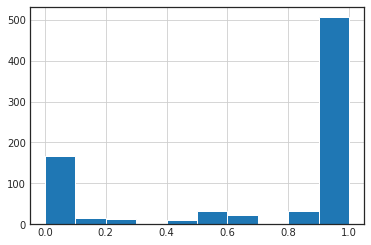

In [159]:
df_valid['ious'].hist();

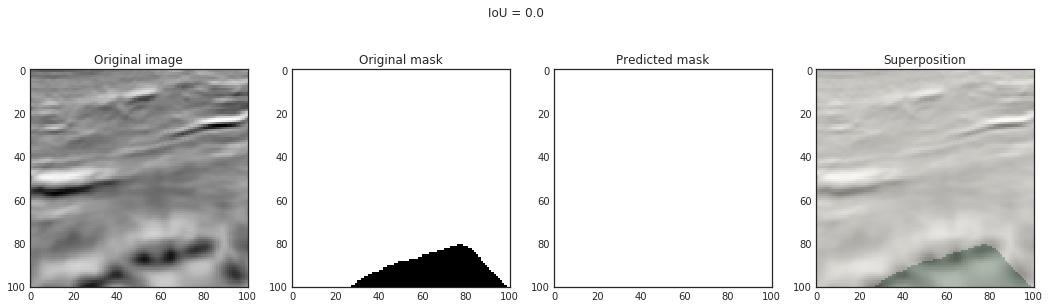

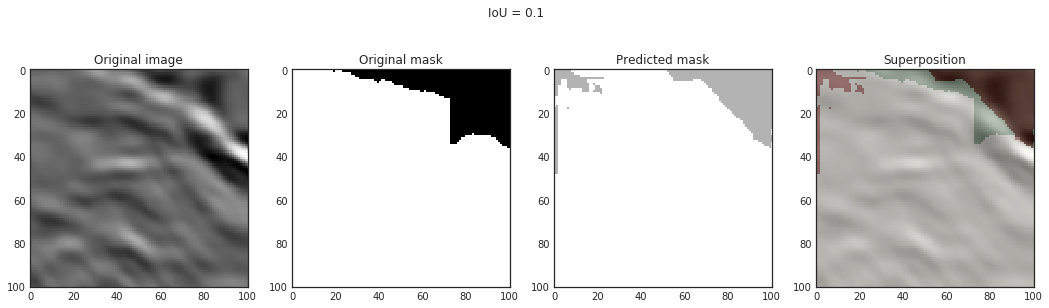

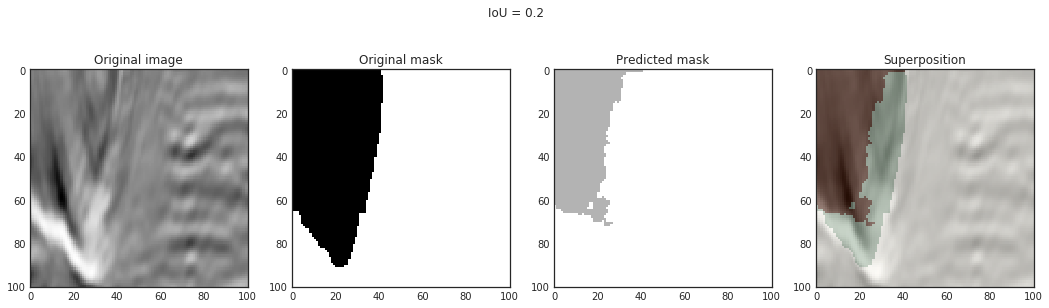

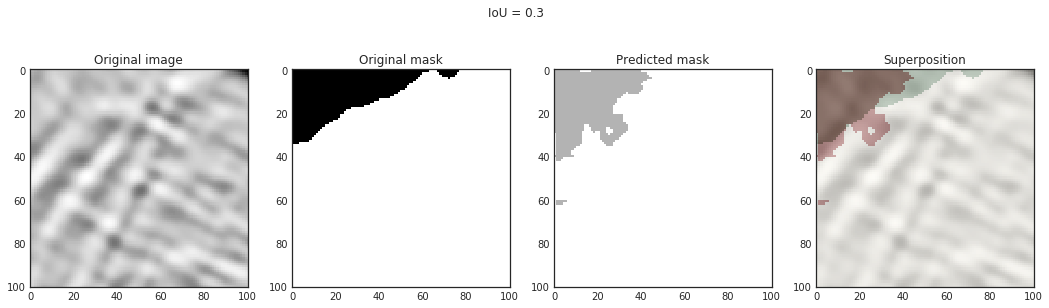

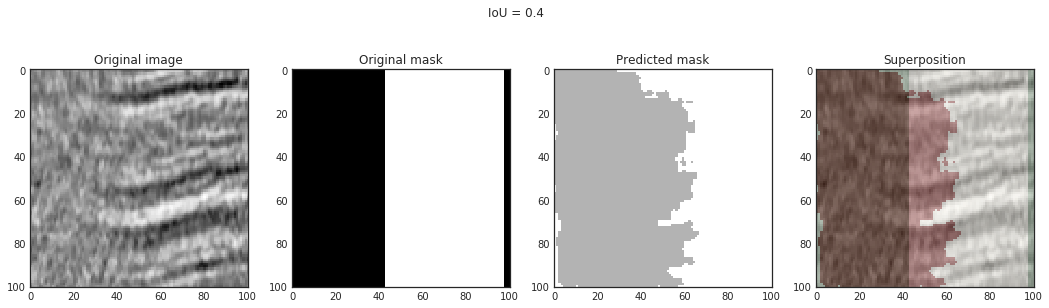

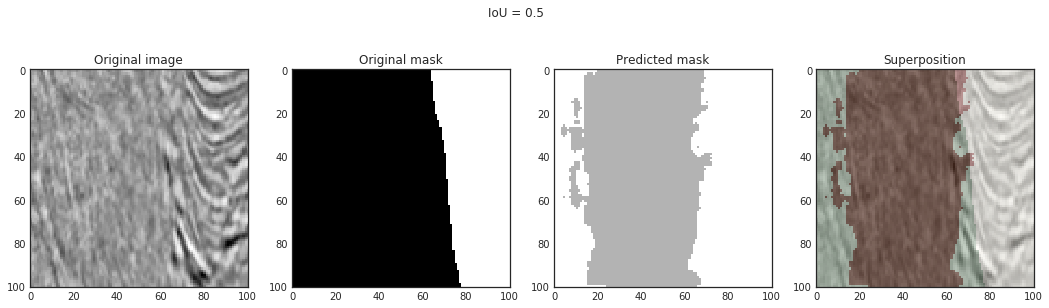

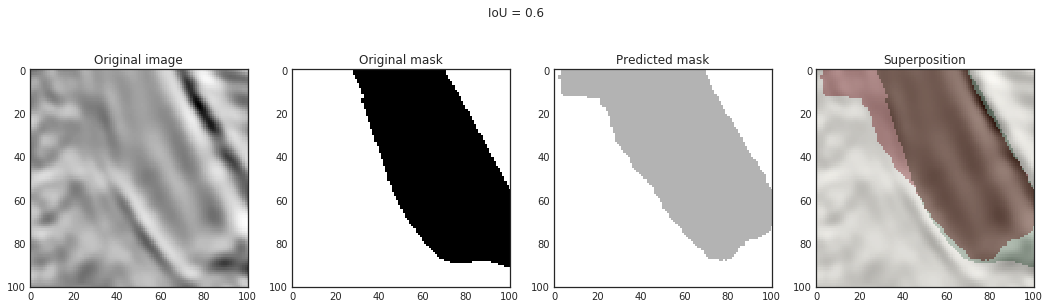

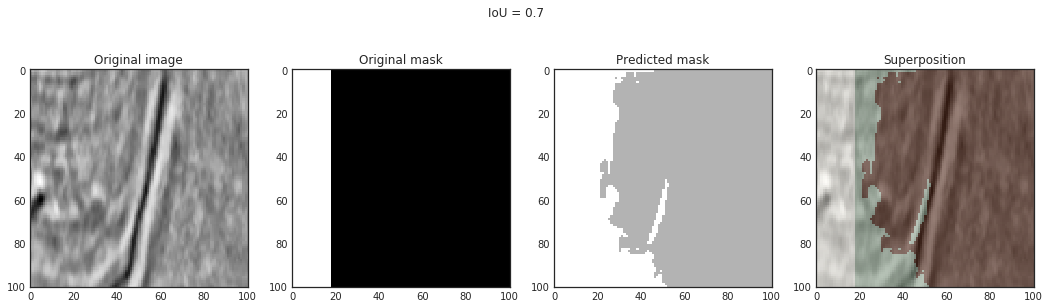

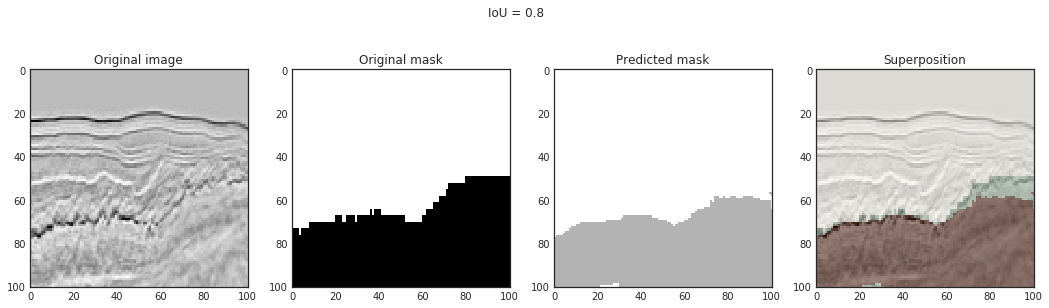

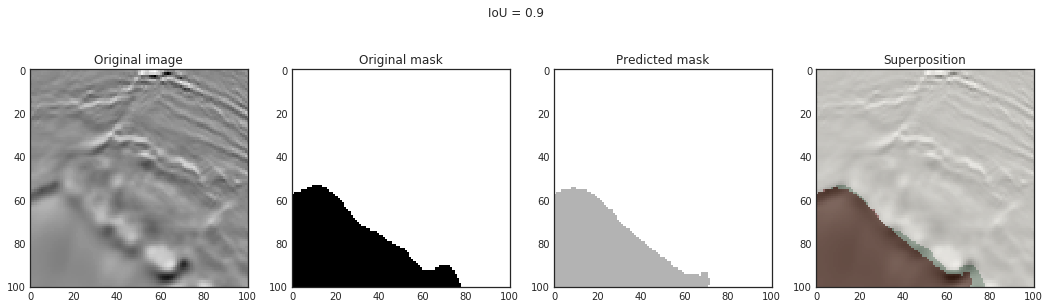

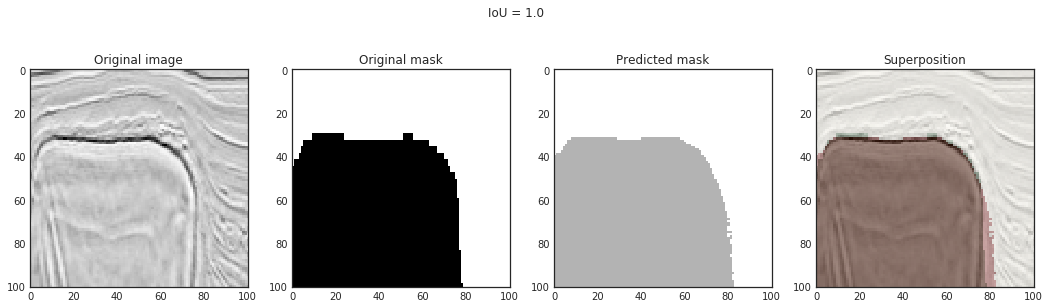

In [160]:
for i in range(11):
    iou = i/10
    indx = choice(df_valid[df_valid.ious==i/10].index)
    img = df_valid.loc[indx].images
    mask = df_valid.loc[indx].masks
    pred_mask = df_valid.loc[indx].pred_mask
    _, ax = plt.subplots(nrows=1, 
                         ncols=4, 
                         figsize=(18, 5))
    ax[0].imshow(img, cmap="Greys");
    ax[0].set_title('Original image')
    ax[1].imshow(mask, cmap="Greys");
    ax[1].set_title('Original mask')
    ax[2].imshow(pred_mask, alpha=0.3, cmap="Greys");
    ax[2].set_title('Predicted mask')
    ax[3].imshow(img, cmap="Greys")
    ax[3].imshow(mask, alpha=0.3, cmap="Greens");
    ax[3].imshow(pred_mask, alpha=0.3, cmap="OrRd");
    ax[3].set_title('Superposition');
    plt.suptitle("IoU = {}".format(iou))
    plt.show()